<a href="https://colab.research.google.com/github/sanabriadiego/hearth-disease-prediction/blob/main/hearth_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score

Dataset:

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

In [2]:
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

Since our data doesn't have column names we assign them according to the UCI website.

In [3]:
df = pd.read_csv('processed.cleveland.data', names=columns)

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


DATA CLEANING

We can see that on our dataset the columns 'ca' and 'thal' are of the type object, because they have numbers and the character '?'. We can check this with the unique() method. ca represents the number of major vessels (0-3) colored by flourosopy.

In [6]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

In [7]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

We transform the object values to float, including the '?' character. The errors = 'coerce' attibute can turn invalid values into NaN. We apply this to columns ca and thal.

In [8]:
df['ca'] = pd.to_numeric(df['ca'], errors='coerce')

In [9]:
df['thal'] = pd.to_numeric(df['thal'], errors='coerce')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


Now we can drop the rows that have a NaN value. For this specific dataset we can consider that since it is a medical application we shouldn't try to infer new values.

In [11]:
df2 = df.copy()
df2 = df2.dropna()

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  num       297 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 34.8 KB


Now we work with df2 and change the values for the num column to only 1 and 0. This column represents our targets: Diagnosis of heart disease (angiographic disease status). According to the UCI website values from 1 to 4 represent the presence of a hearth disease (1).

Value 0: < 50% diameter narrowing.  
Value 1: > 50% diameter narrowing


In [13]:
df2['num'].unique()

array([0, 2, 1, 3, 4])

In [14]:
df2.loc[df2["num"] != 0, "num"] = 1

In [15]:
df2['num'].unique()

array([0, 1])

In [16]:
df2['num'].value_counts()

0    160
1    137
Name: num, dtype: int64

We don't see a major difference between 0 and 1 cases so we proceed with a Data Visualization.

DATA VISUALIZATION

<Axes: xlabel='age', ylabel='Count'>

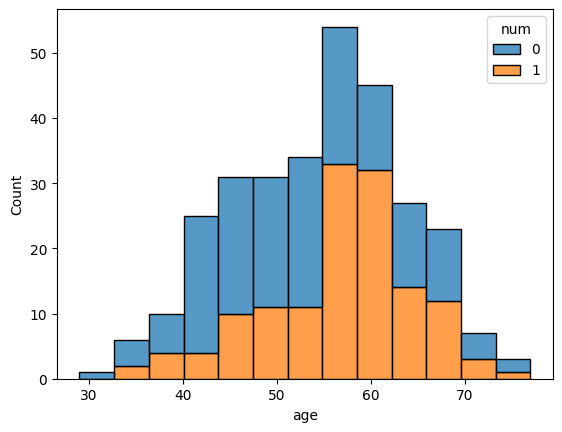

In [17]:
sns.histplot(data=df2, x='age', hue='num', multiple="stack")

This graph show the amount of patients we have based on their age. Most of them are between 50 and 60 years old. We can also see that most of the patients with a hearth disease are around 60 years old.

<Axes: xlabel='age', ylabel='chol'>

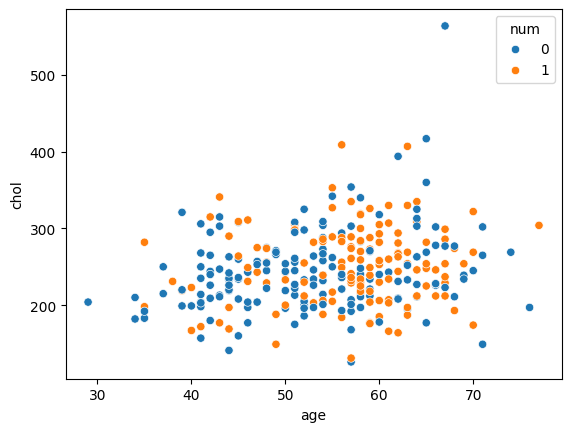

In [18]:
sns.scatterplot(x=df2['age'], y=df2['chol'], hue=df2['num'])

This graph shows us the relation that exists between cholesterol and the age of patients.

ALGORITHM ANALYSIS

In [19]:
X = df2[columns[:-1]]
y = df2[columns[-1]]

In [20]:
df2.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,0.499340
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


Now we split our data so we can work on different algorithms and check the accuracy for each of them. Which algorithm is better?
We set 20% for our test data and the rest for our training data.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [22]:
print(f"the shape of the training set (input) is: {X_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the test set (input) is: {X_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (237, 13)
the shape of the training set (target) is: (237,)

the shape of the test set (input) is: (60, 13)
the shape of the test set (target) is: (60,)


We need to scale the values so we can easily work on them, there is a big difference between the values of the columns.

In [23]:
scaler = StandardScaler().fit(X_train)
x_train_norm = scaler.transform(X_train)

In [24]:
scaler_test = StandardScaler().fit(X_test)
x_test_norm = scaler.transform(X_test)

In order to find the best hyperparameters, we use a combination of RepeatedStratifiedKFold function and GridSearch CV. We will apply this to each algorithm we use.

Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
lr = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [27]:
param_grid = {
    'C': [100, 10, 1.0, 0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': [100, 200, 300],
    'penalty': ['l2']
}

In [28]:
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

In [29]:
grid_result = grid_search.fit(x_train_norm, y_train)

In [30]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.837077 using {'C': 1.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.832790 (0.078760) with: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.832790 (0.078760) with: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.832790 (0.078760) with: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.832790 (0.078760) with: {'C': 100, 'max_iter': 200, 'penalty': 'l2', 'solver': 'newton-cg'}
0.832790 (0.078760) with: {'C': 100, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}
0.832790 (0.078760) with: {'C': 100, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
0.832790 (0.078760) with: {'C': 100, 'max_iter': 300, 'penalty': 'l2', 'solver': 'newton-cg'}
0.832790 (0.078760) with: {'C': 100, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}
0.832790 (0.078760) with: {'C': 100, 'max_iter': 300, 'penalty': 'l2', 'solver': 'liblinear'}
0.834239 (0.079023) with: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver

We then produce a new model based on the best hyperparameters we just found.

In [69]:
model_lr = LogisticRegression(C=1, max_iter=100, penalty='l2', solver='newton-cg')

In [70]:
model_lr.fit(x_train_norm, y_train)

LogisticRegression(C=1, solver='newton-cg')

In [71]:
y_pred_lr = model_lr.predict(x_test_norm)

In [72]:
print("Classification Report for Logistic Regression: \n", classification_report(y_test, y_pred_lr))

Classification Report for Logistic Regression: 
               precision    recall  f1-score   support

           0       0.82      0.77      0.79        30
           1       0.78      0.83      0.81        30

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60



K Nearest Neighbor

In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [35]:
knn = KNeighborsClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [36]:
param_grid = {
    'n_neighbors': range(1, 21, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [37]:
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train_norm, y_train)

In [38]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.843659 using {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}
0.727295 (0.082951) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.727295 (0.082951) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.783273 (0.088418) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.787500 (0.084809) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.811473 (0.074587) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.812862 (0.075365) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.801510 (0.080908) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.802899 (0.081085) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.814130 (0.070029) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.808514 (0.071069) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.811413 

In [39]:
knn_model = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 15, weights= 'uniform')
knn_model.fit(x_train_norm, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=15)

In [40]:
y_pred_knn = knn_model.predict(x_test_norm)

In [41]:
print("Classification Report for KNN: \n", classification_report(y_test, y_pred_knn))

Classification Report for KNN: 
               precision    recall  f1-score   support

           0       0.79      0.90      0.84        30
           1       0.88      0.77      0.82        30

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60



SUPPORT VECTOR MACHINE

In [42]:
from sklearn.svm import SVC

In [43]:
svm = SVC()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [44]:
param_grid = {
    'kernel' : ['poly', 'rbf', 'sigmoid'],
    'C' : [50, 10, 1.0, 0.1, 0.01],
    'gamma' : ['scale']
}

In [45]:
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train_norm, y_train)

In [46]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.841184 using {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.748188 (0.078366) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.761896 (0.091620) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.791848 (0.072757) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.760568 (0.087615) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.777053 (0.089784) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.788889 (0.083776) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.801449 (0.077127) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.805737 (0.066881) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.841184 (0.072839) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.738466 (0.067258) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.821135 (0.080565) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.840942 (0.074154) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.550121 (0.012361) with: {'C': 0.01, 'gamma': 'sca

In [47]:
svm_model = SVC(C= 1.0, gamma= 'scale', kernel= 'sigmoid')
svm_model.fit(x_train_norm, y_train)

SVC(kernel='sigmoid')

In [48]:
y_pred_svc = svm_model.predict(x_test_norm)

In [49]:
print("Classification Report for Support Vector Machine: \n", classification_report(y_test, y_pred_svc))

Classification Report for Support Vector Machine: 
               precision    recall  f1-score   support

           0       0.88      0.93      0.90        30
           1       0.93      0.87      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



RANDOM FOREST

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
rf = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [52]:
param_grid = {
    'n_estimators': [10, 100, 1000],
    'max_features': ['sqrt', 'log2']
}

In [53]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train_norm, y_train)

In [54]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.807307 using {'max_features': 'log2', 'n_estimators': 100}
0.790036 (0.086692) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.797524 (0.073237) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.804589 (0.073438) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.798611 (0.090701) with: {'max_features': 'log2', 'n_estimators': 10}
0.807307 (0.080121) with: {'max_features': 'log2', 'n_estimators': 100}
0.805857 (0.069932) with: {'max_features': 'log2', 'n_estimators': 1000}


In [55]:
rf_model = RandomForestClassifier(max_features= 'log2', n_estimators= 1000)
rf_model.fit(x_train_norm, y_train)

RandomForestClassifier(max_features='log2', n_estimators=1000)

In [56]:
y_pred_rf = rf_model.predict(x_test_norm)

In [57]:
print("Classification Report for Support Vector Machine: \n", classification_report(y_test, y_pred_rf))

Classification Report for Support Vector Machine: 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.89      0.83      0.86        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



NEURAL NETWORKS

In [58]:
import tensorflow as tf

We start defining a plot function that will show us first the behavior of the loss versus the epochs, and the accuracy vs the epochs as we keep trying different values for our parameters.

In [59]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

We also define a function that will help us go though all our parameters and change them. The validation split is defined as 20%, similar to our other algorithms.

In [60]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(13,)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(num_nodes, activation='relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
  history = nn_model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
  )

  return nn_model, history

#dropout layers helps prevent overfitting

Then we set all the values we want to try, and we get the model that has the least loss, since this is the model we need.

16 nodes, dropout 0, lr 0.01, batch size 32


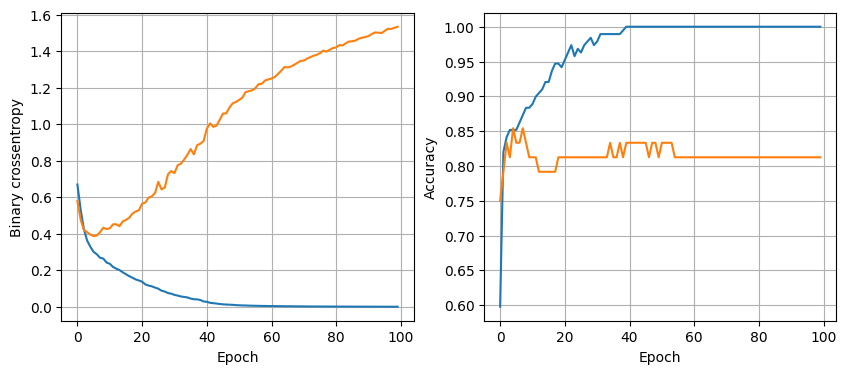

2/2 [==============================] - 0s 9ms/step - loss: 2.9363 - accuracy: 0.7500
16 nodes, dropout 0, lr 0.01, batch size 64


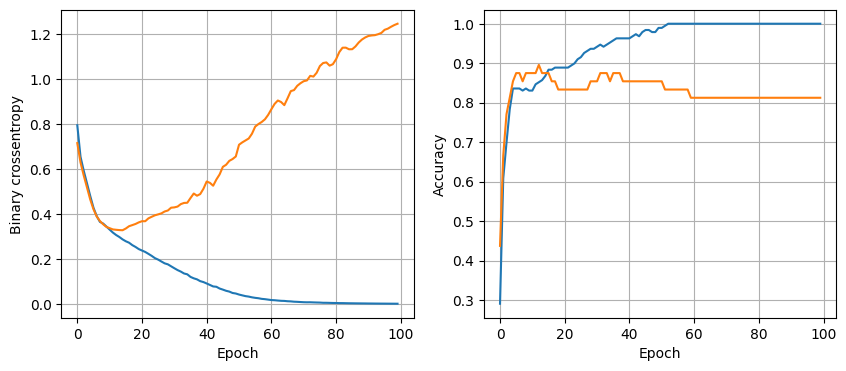

2/2 [==============================] - 0s 8ms/step - loss: 2.3588 - accuracy: 0.7333
16 nodes, dropout 0, lr 0.01, batch size 128


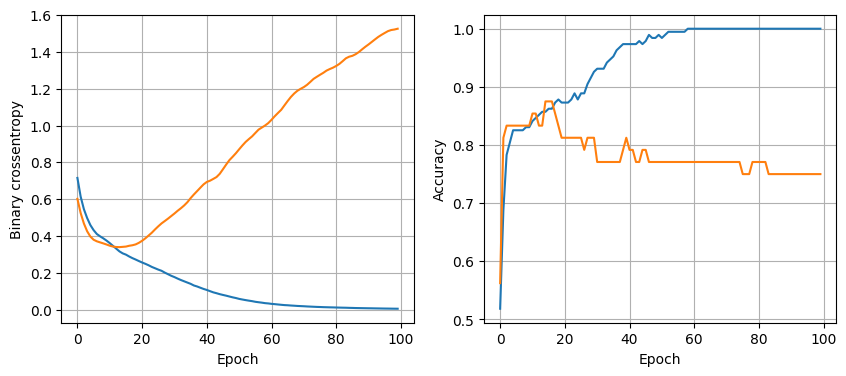

2/2 [==============================] - 0s 7ms/step - loss: 2.3434 - accuracy: 0.8000
16 nodes, dropout 0, lr 0.005, batch size 32


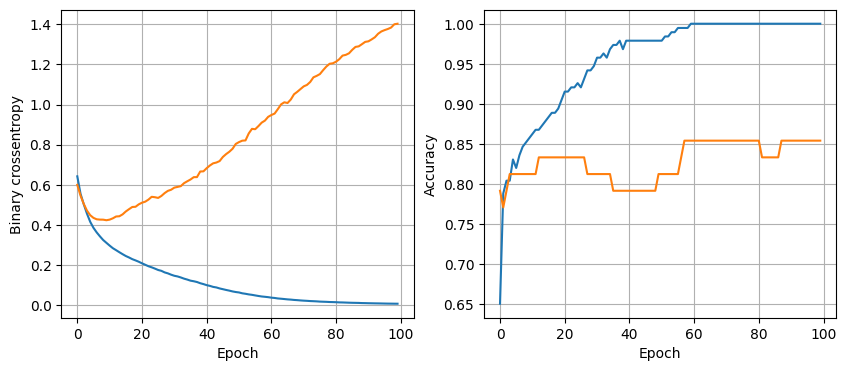

2/2 [==============================] - 0s 8ms/step - loss: 1.4135 - accuracy: 0.8000
16 nodes, dropout 0, lr 0.005, batch size 64


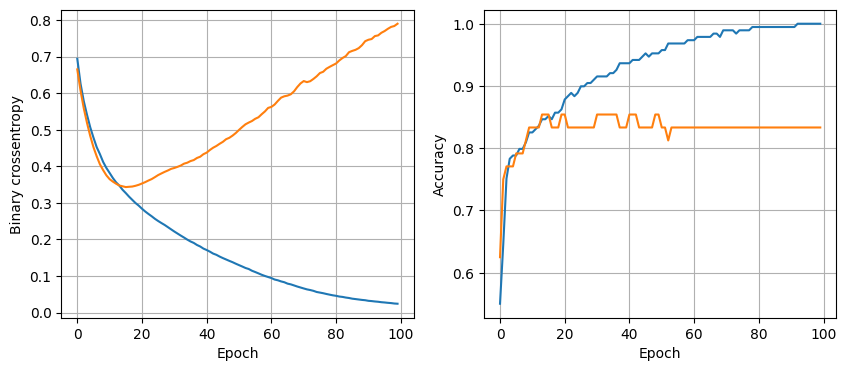

2/2 [==============================] - 0s 10ms/step - loss: 1.3461 - accuracy: 0.7667
16 nodes, dropout 0, lr 0.005, batch size 128


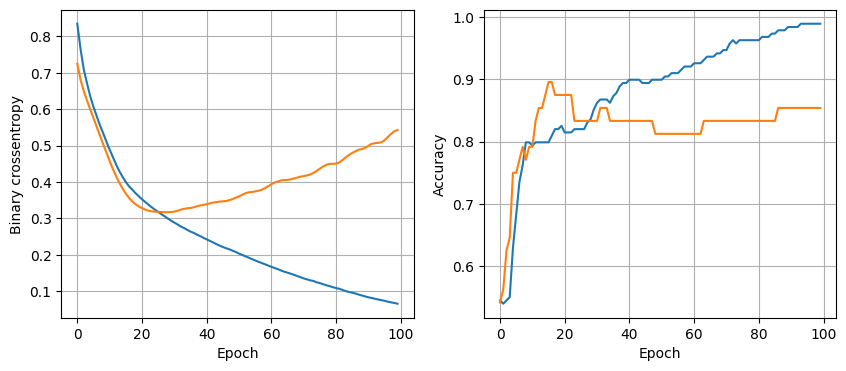

2/2 [==============================] - 0s 7ms/step - loss: 1.0127 - accuracy: 0.7667
16 nodes, dropout 0, lr 0.001, batch size 32


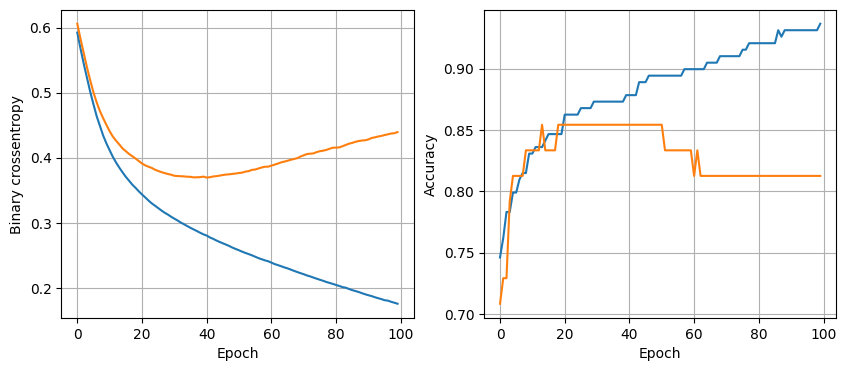

2/2 [==============================] - 0s 7ms/step - loss: 0.6201 - accuracy: 0.7833
16 nodes, dropout 0, lr 0.001, batch size 64


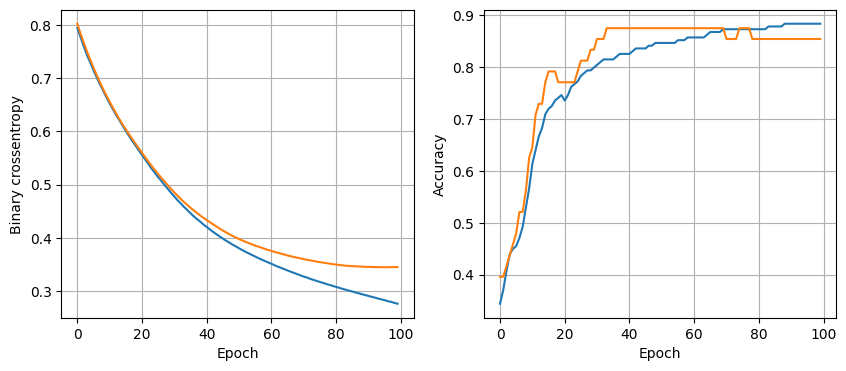

2/2 [==============================] - 0s 6ms/step - loss: 0.4161 - accuracy: 0.8500
16 nodes, dropout 0, lr 0.001, batch size 128


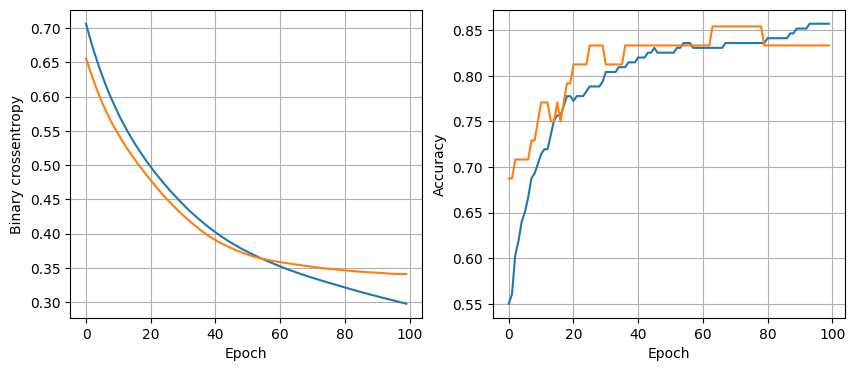

2/2 [==============================] - 0s 11ms/step - loss: 0.4061 - accuracy: 0.8333
16 nodes, dropout 0.2, lr 0.01, batch size 32


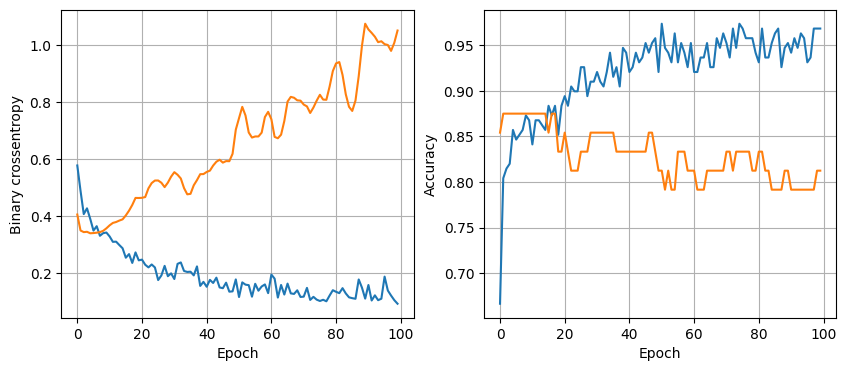

2/2 [==============================] - 0s 7ms/step - loss: 1.6278 - accuracy: 0.7833
16 nodes, dropout 0.2, lr 0.01, batch size 64


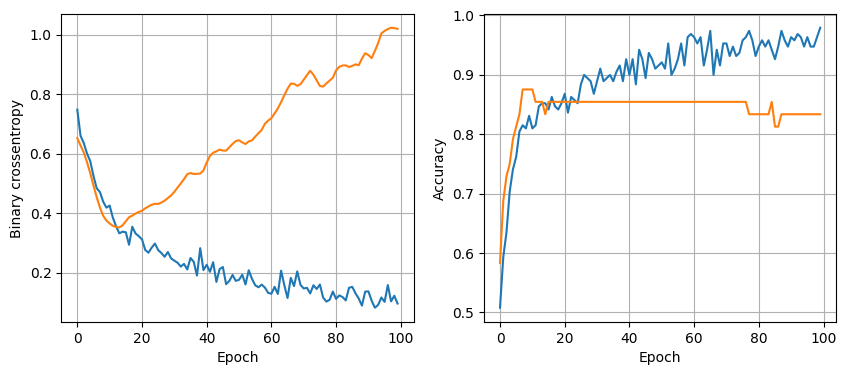

2/2 [==============================] - 0s 8ms/step - loss: 1.1959 - accuracy: 0.8000
16 nodes, dropout 0.2, lr 0.01, batch size 128


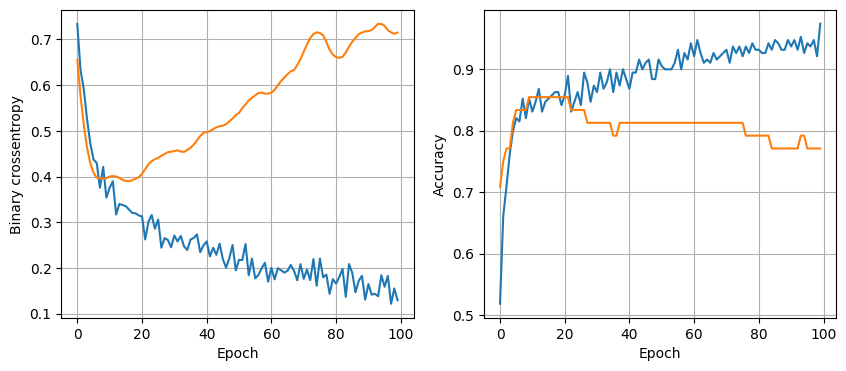

2/2 [==============================] - 0s 10ms/step - loss: 0.8246 - accuracy: 0.8167
16 nodes, dropout 0.2, lr 0.005, batch size 32


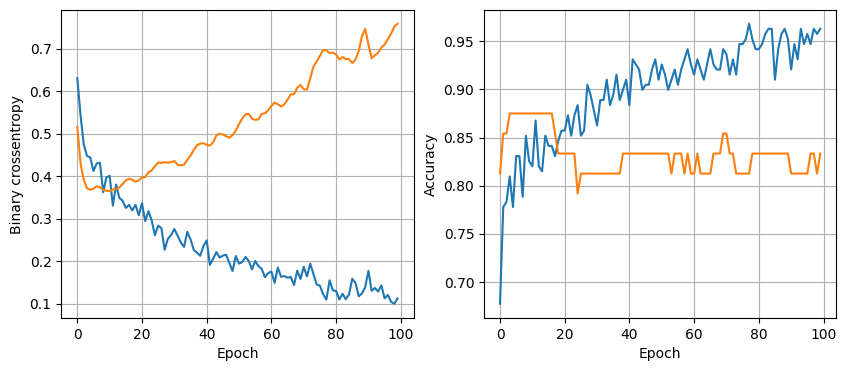

2/2 [==============================] - 0s 8ms/step - loss: 1.2875 - accuracy: 0.7833
16 nodes, dropout 0.2, lr 0.005, batch size 64


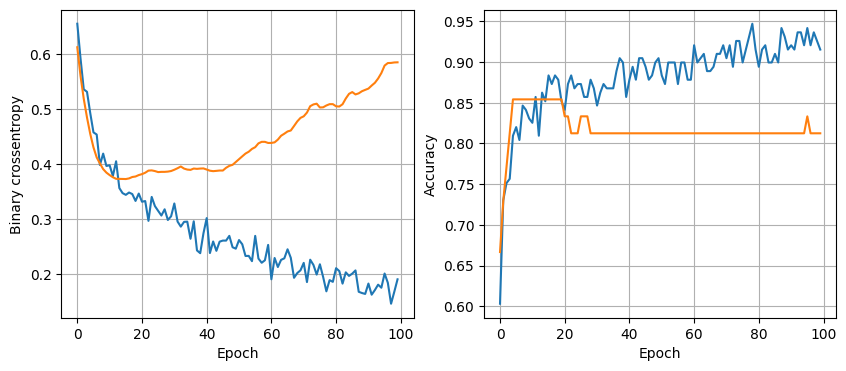

2/2 [==============================] - 0s 11ms/step - loss: 0.9917 - accuracy: 0.7333
16 nodes, dropout 0.2, lr 0.005, batch size 128


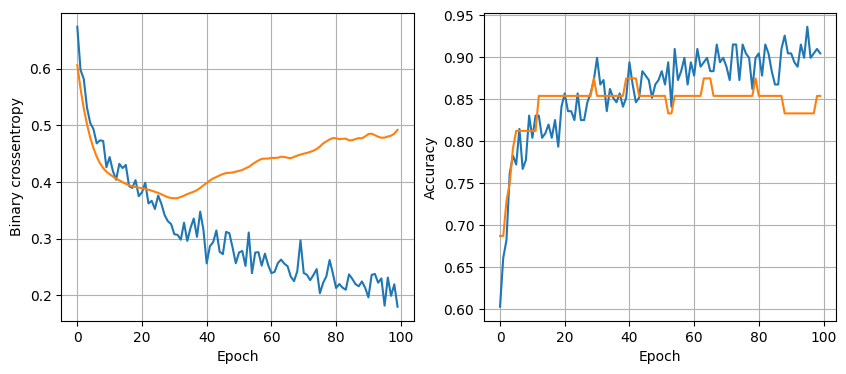

2/2 [==============================] - 0s 8ms/step - loss: 0.7864 - accuracy: 0.7667
16 nodes, dropout 0.2, lr 0.001, batch size 32


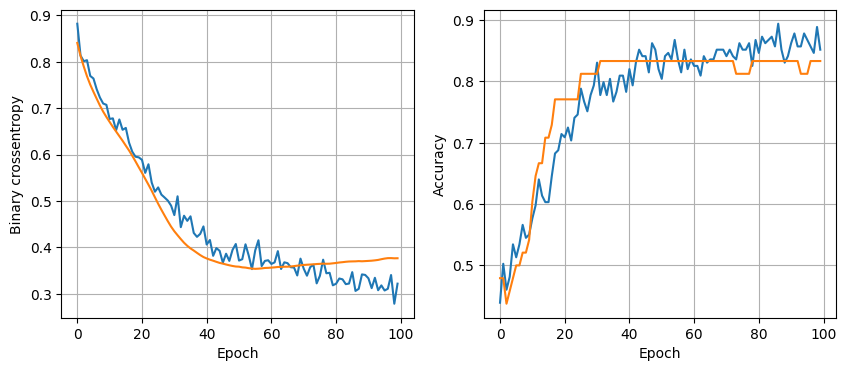

2/2 [==============================] - 0s 8ms/step - loss: 0.5132 - accuracy: 0.8333
16 nodes, dropout 0.2, lr 0.001, batch size 64


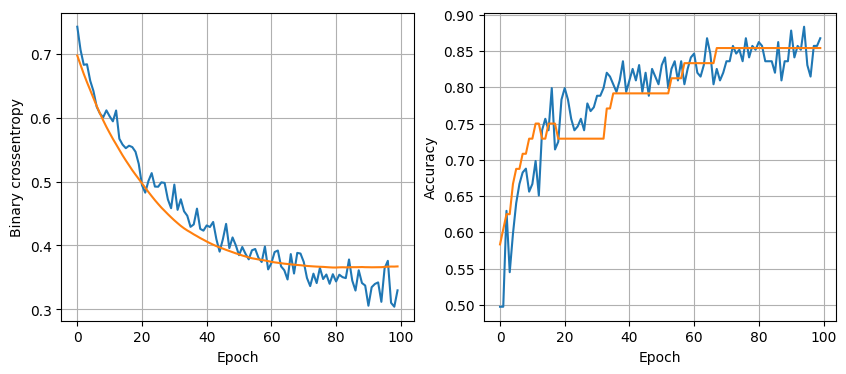

2/2 [==============================] - 0s 7ms/step - loss: 0.4230 - accuracy: 0.8833
16 nodes, dropout 0.2, lr 0.001, batch size 128


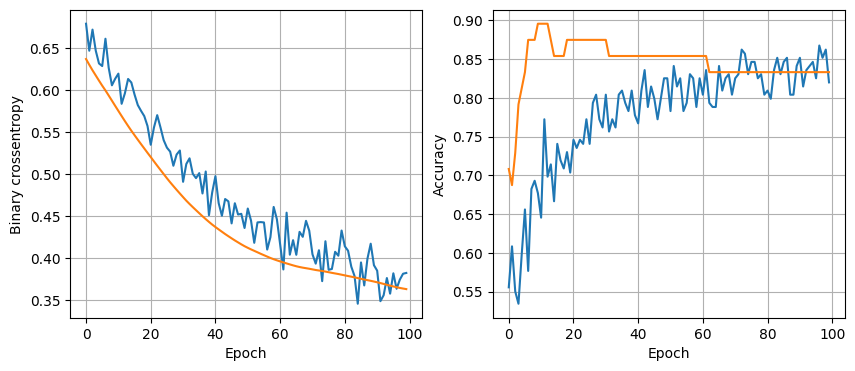

2/2 [==============================] - 0s 7ms/step - loss: 0.4514 - accuracy: 0.8333
32 nodes, dropout 0, lr 0.01, batch size 32


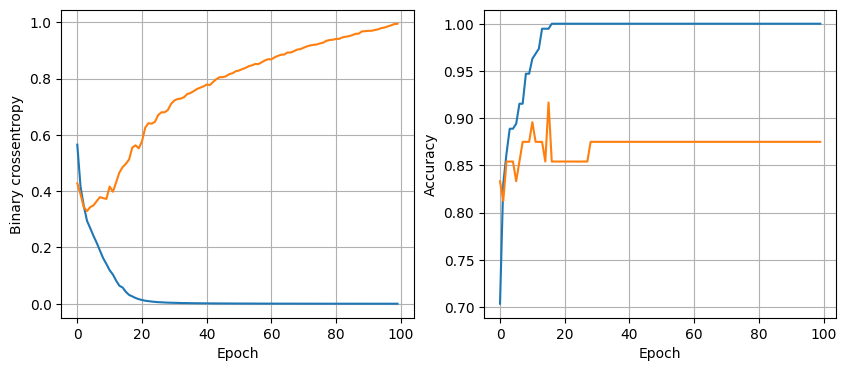

2/2 [==============================] - 0s 9ms/step - loss: 4.0832 - accuracy: 0.7000
32 nodes, dropout 0, lr 0.01, batch size 64


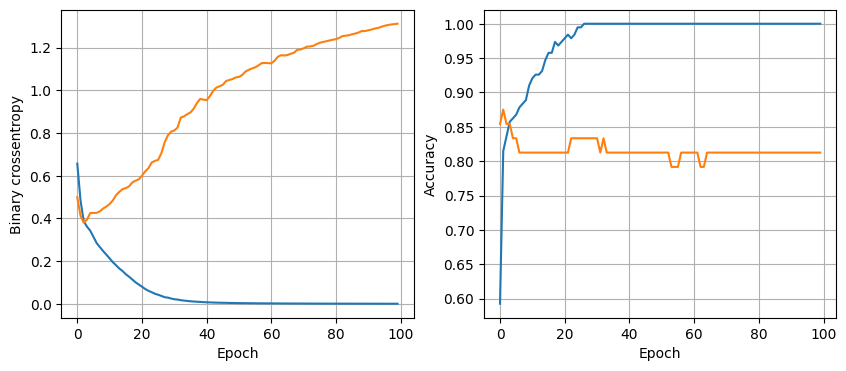

2/2 [==============================] - 0s 14ms/step - loss: 2.7834 - accuracy: 0.7500
32 nodes, dropout 0, lr 0.01, batch size 128


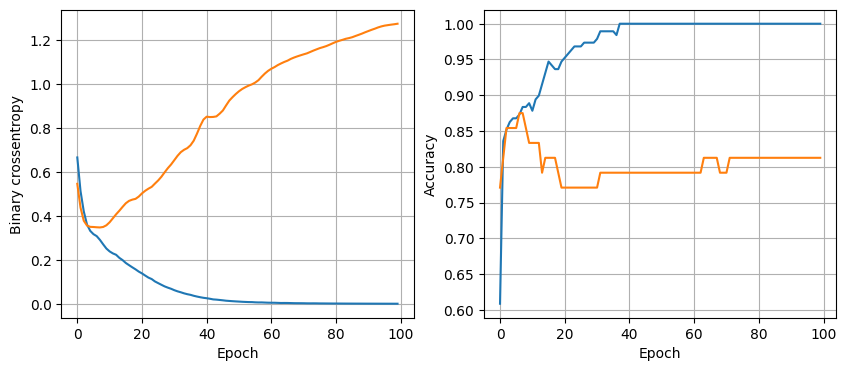

2/2 [==============================] - 0s 7ms/step - loss: 2.9418 - accuracy: 0.7500
32 nodes, dropout 0, lr 0.005, batch size 32


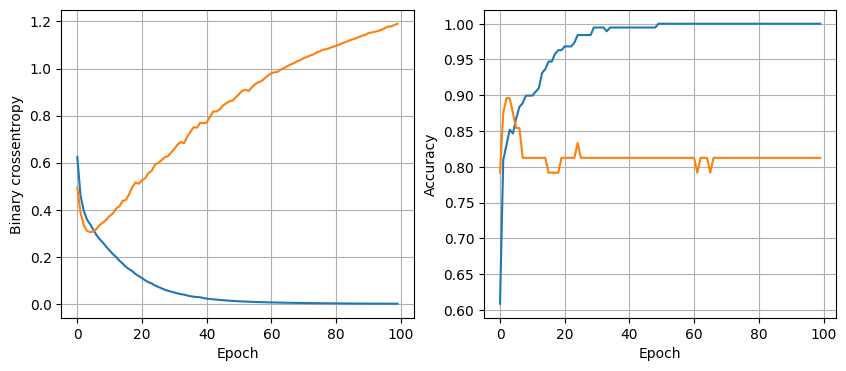

2/2 [==============================] - 0s 8ms/step - loss: 2.3739 - accuracy: 0.7333
32 nodes, dropout 0, lr 0.005, batch size 64


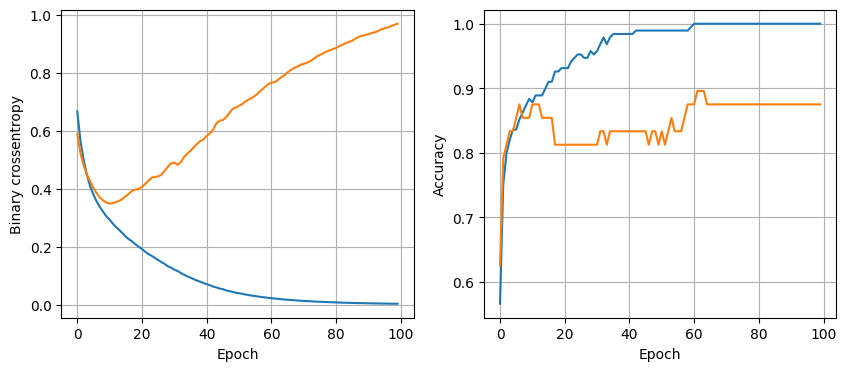

2/2 [==============================] - 0s 8ms/step - loss: 2.4998 - accuracy: 0.7333
32 nodes, dropout 0, lr 0.005, batch size 128


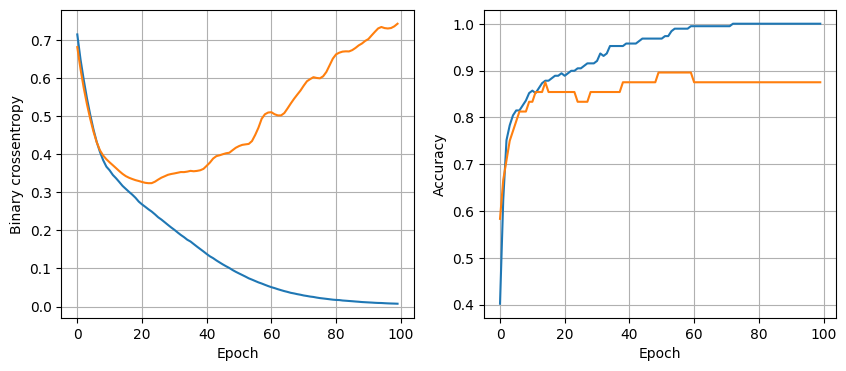

2/2 [==============================] - 0s 7ms/step - loss: 2.1811 - accuracy: 0.7500
32 nodes, dropout 0, lr 0.001, batch size 32


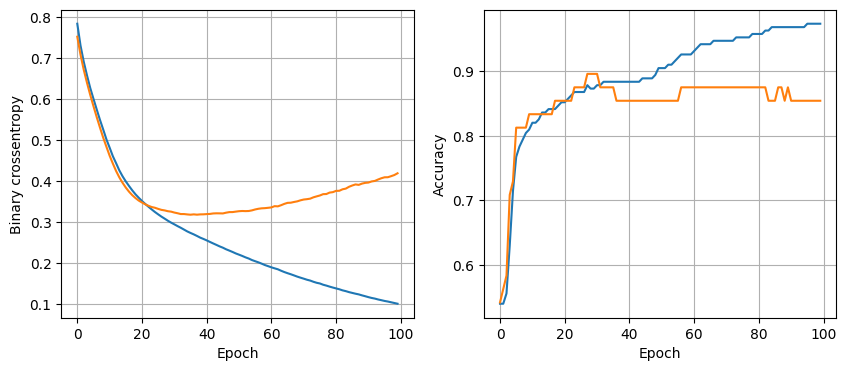

2/2 [==============================] - 0s 14ms/step - loss: 0.6862 - accuracy: 0.7667
32 nodes, dropout 0, lr 0.001, batch size 64


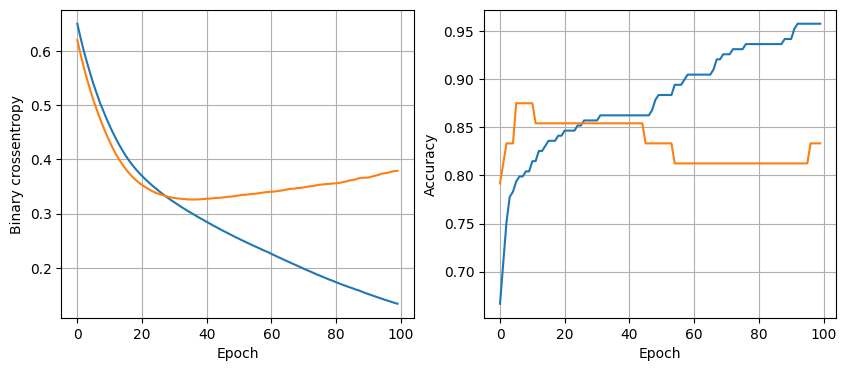

2/2 [==============================] - 0s 15ms/step - loss: 0.6277 - accuracy: 0.7833
32 nodes, dropout 0, lr 0.001, batch size 128


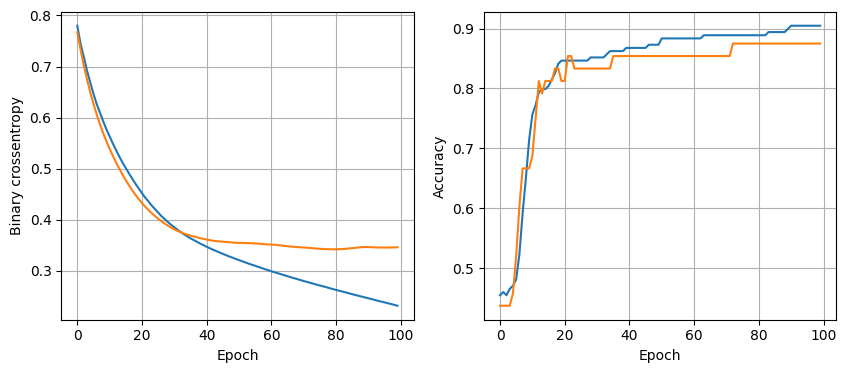

2/2 [==============================] - 0s 17ms/step - loss: 0.5145 - accuracy: 0.8500
32 nodes, dropout 0.2, lr 0.01, batch size 32


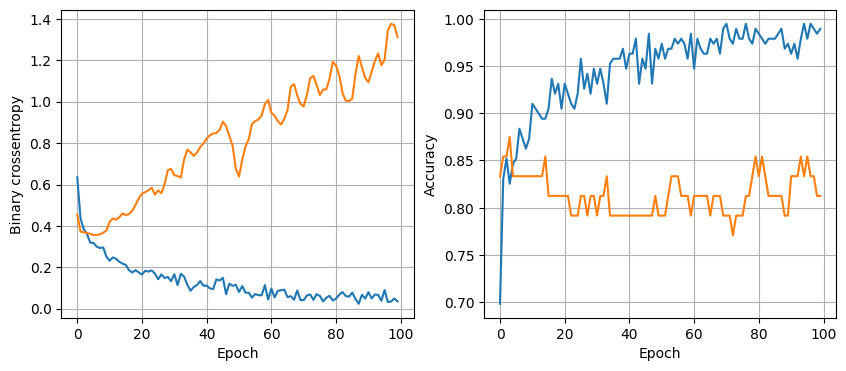

2/2 [==============================] - 0s 7ms/step - loss: 1.9231 - accuracy: 0.7833
32 nodes, dropout 0.2, lr 0.01, batch size 64


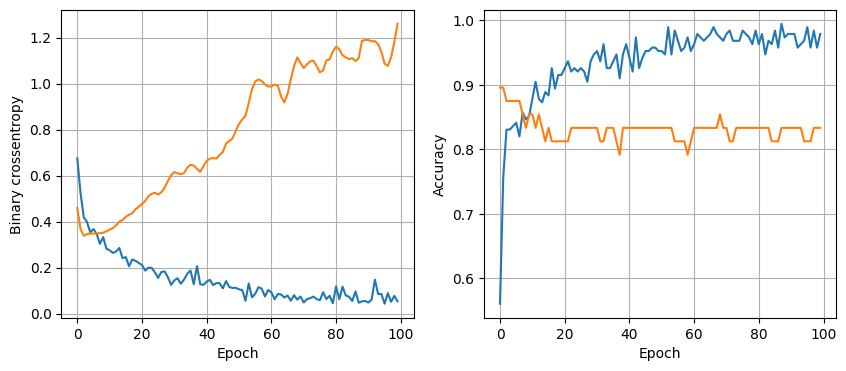

2/2 [==============================] - 0s 8ms/step - loss: 1.7143 - accuracy: 0.7833
32 nodes, dropout 0.2, lr 0.01, batch size 128


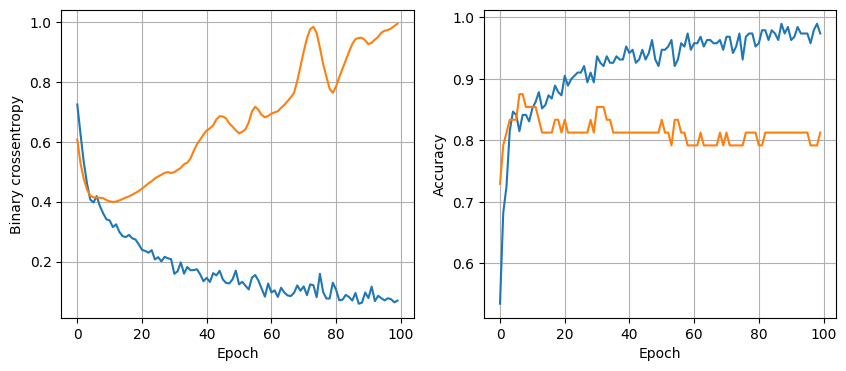

2/2 [==============================] - 0s 7ms/step - loss: 1.5088 - accuracy: 0.8167
32 nodes, dropout 0.2, lr 0.005, batch size 32


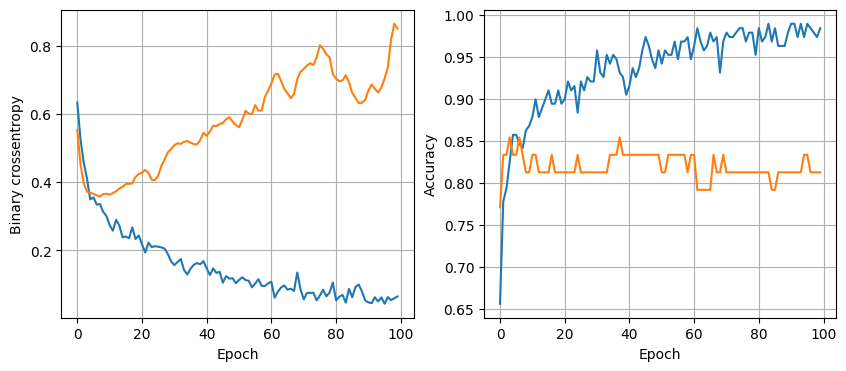

2/2 [==============================] - 0s 9ms/step - loss: 1.6087 - accuracy: 0.7667
32 nodes, dropout 0.2, lr 0.005, batch size 64


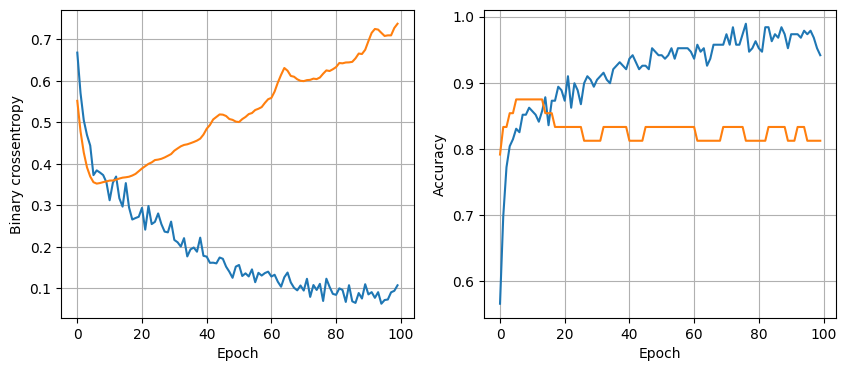

2/2 [==============================] - 0s 12ms/step - loss: 1.3540 - accuracy: 0.8167
32 nodes, dropout 0.2, lr 0.005, batch size 128


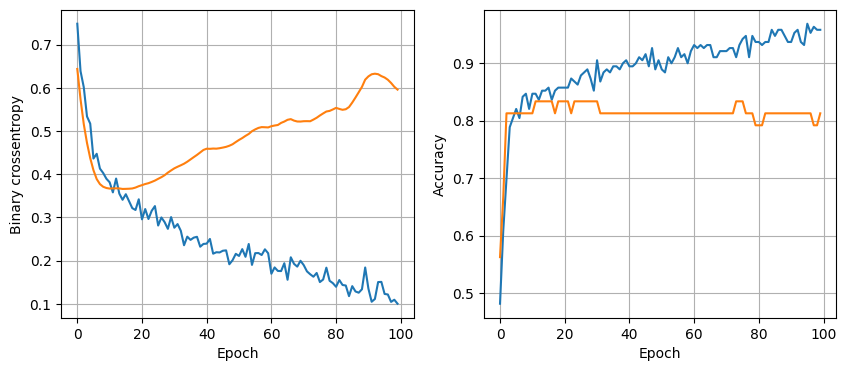

2/2 [==============================] - 0s 8ms/step - loss: 1.0898 - accuracy: 0.7667
32 nodes, dropout 0.2, lr 0.001, batch size 32


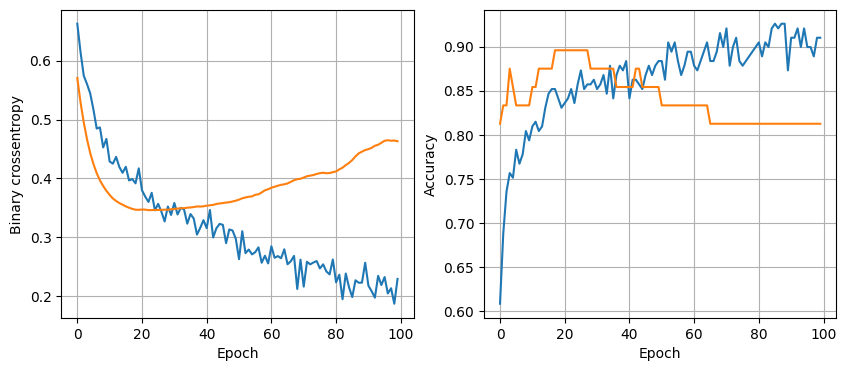

2/2 [==============================] - 0s 7ms/step - loss: 0.7035 - accuracy: 0.8167
32 nodes, dropout 0.2, lr 0.001, batch size 64


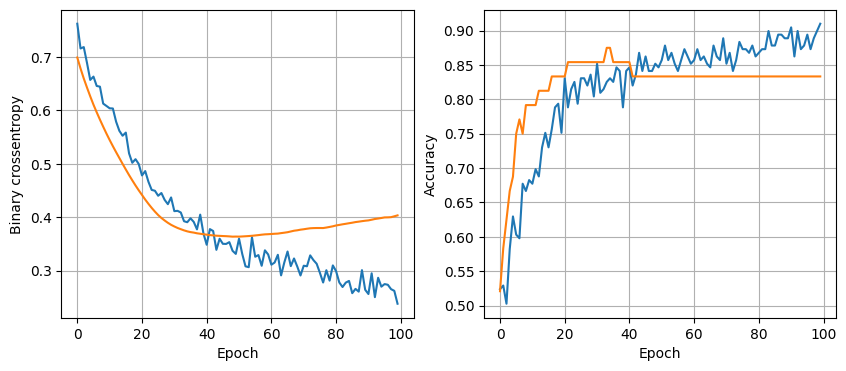

2/2 [==============================] - 0s 8ms/step - loss: 0.4607 - accuracy: 0.8500
32 nodes, dropout 0.2, lr 0.001, batch size 128


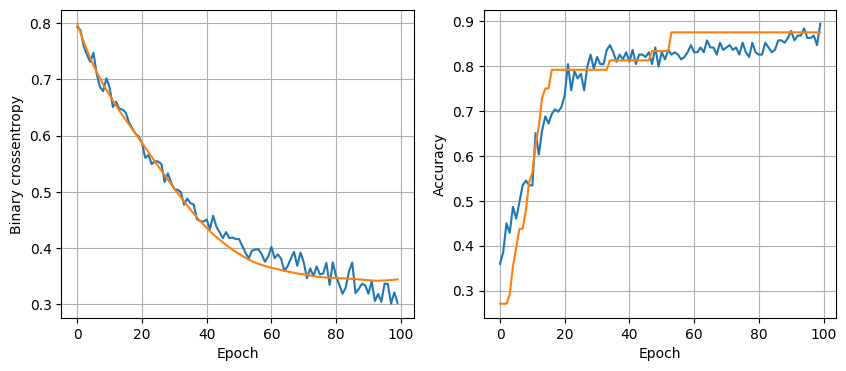

2/2 [==============================] - 0s 8ms/step - loss: 0.4530 - accuracy: 0.8167
64 nodes, dropout 0, lr 0.01, batch size 32


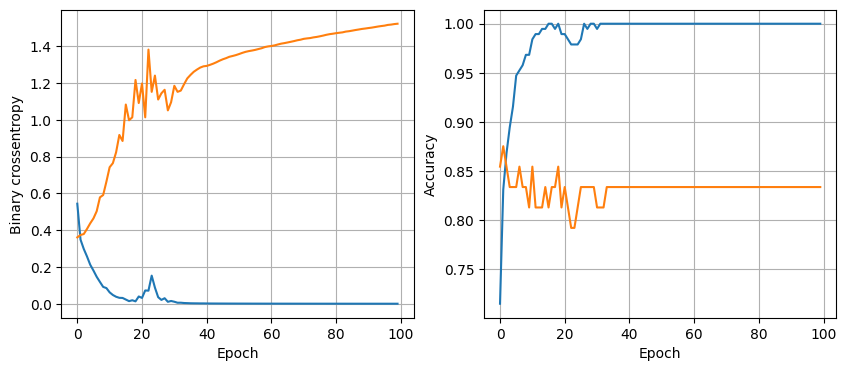

2/2 [==============================] - 0s 9ms/step - loss: 2.9931 - accuracy: 0.7833
64 nodes, dropout 0, lr 0.01, batch size 64


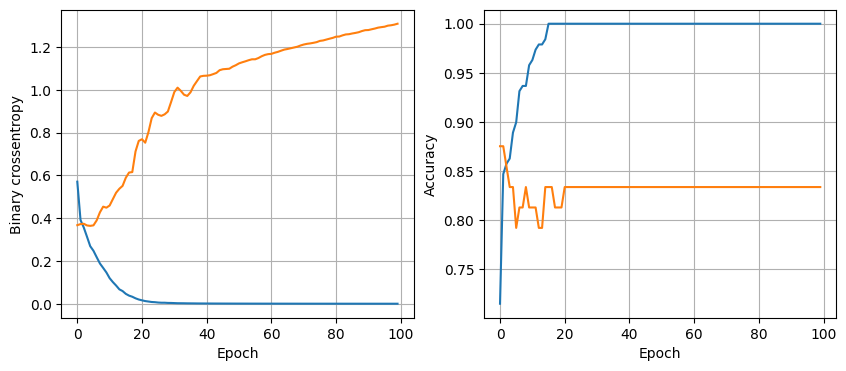

2/2 [==============================] - 0s 8ms/step - loss: 3.3144 - accuracy: 0.7167
64 nodes, dropout 0, lr 0.01, batch size 128


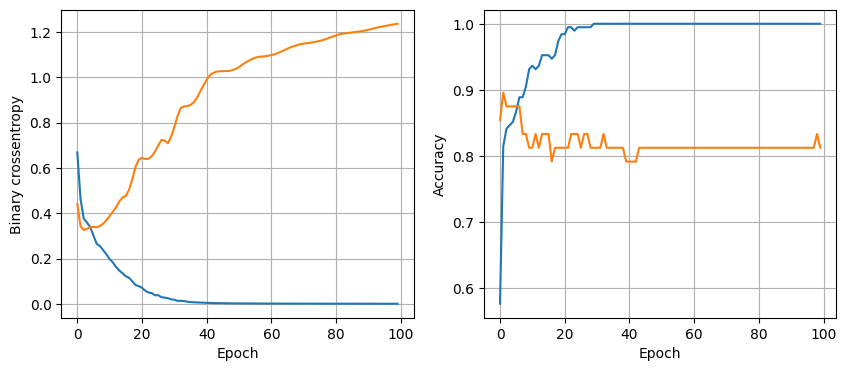

2/2 [==============================] - 0s 8ms/step - loss: 3.0743 - accuracy: 0.7500
64 nodes, dropout 0, lr 0.005, batch size 32


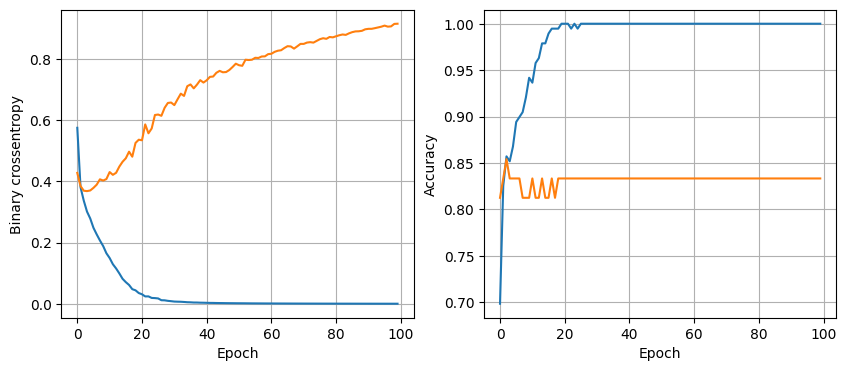

2/2 [==============================] - 0s 6ms/step - loss: 2.6450 - accuracy: 0.7167
64 nodes, dropout 0, lr 0.005, batch size 64


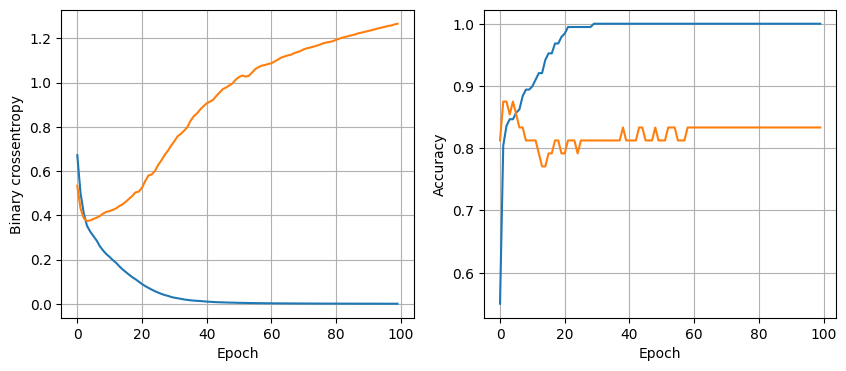

2/2 [==============================] - 0s 6ms/step - loss: 2.4694 - accuracy: 0.7667
64 nodes, dropout 0, lr 0.005, batch size 128


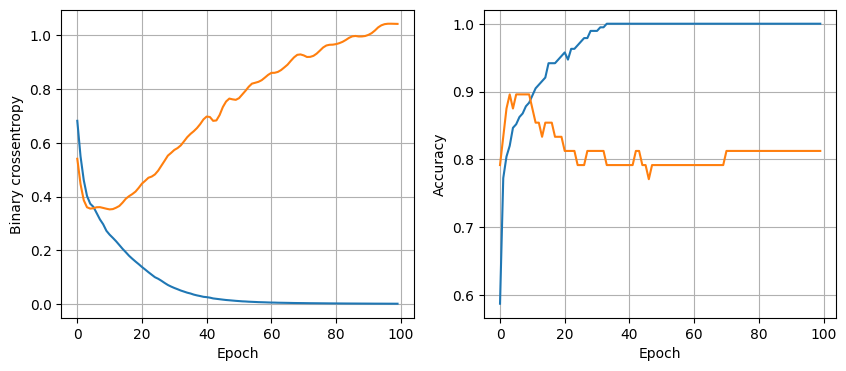

2/2 [==============================] - 0s 9ms/step - loss: 1.7999 - accuracy: 0.7667
64 nodes, dropout 0, lr 0.001, batch size 32


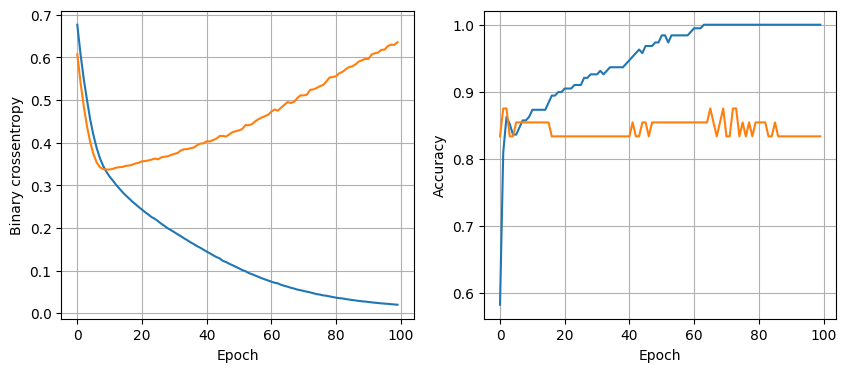

2/2 [==============================] - 0s 10ms/step - loss: 1.0717 - accuracy: 0.7833
64 nodes, dropout 0, lr 0.001, batch size 64


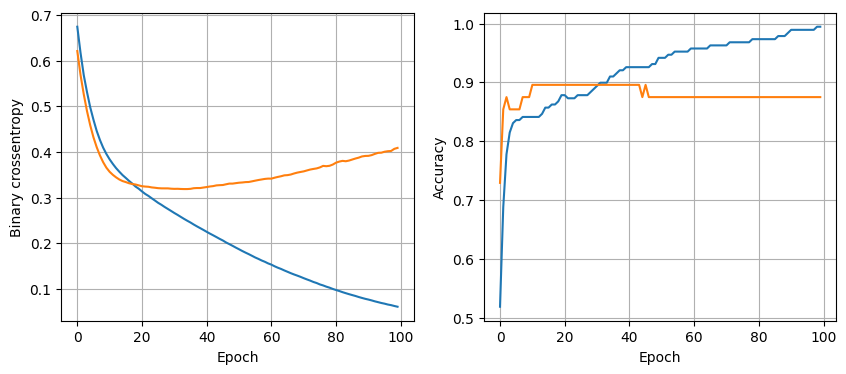

2/2 [==============================] - 0s 7ms/step - loss: 0.9593 - accuracy: 0.7500
64 nodes, dropout 0, lr 0.001, batch size 128


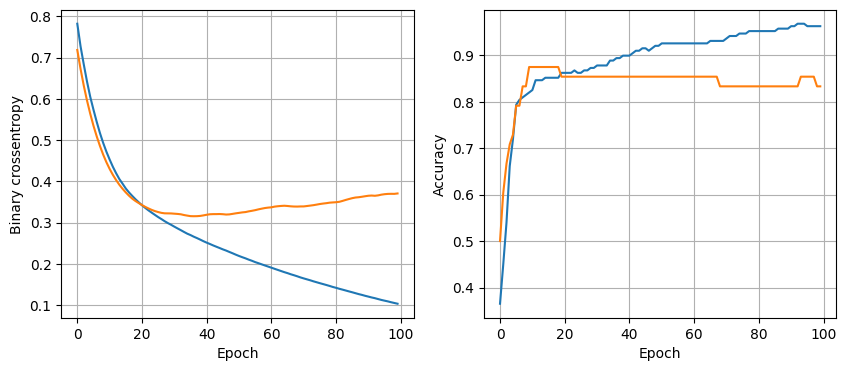

2/2 [==============================] - 0s 7ms/step - loss: 0.7430 - accuracy: 0.7667
64 nodes, dropout 0.2, lr 0.01, batch size 32


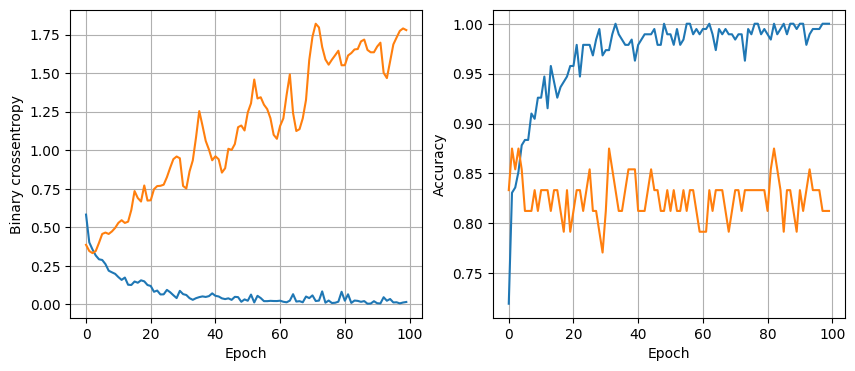

2/2 [==============================] - 0s 7ms/step - loss: 3.7208 - accuracy: 0.8000
64 nodes, dropout 0.2, lr 0.01, batch size 64


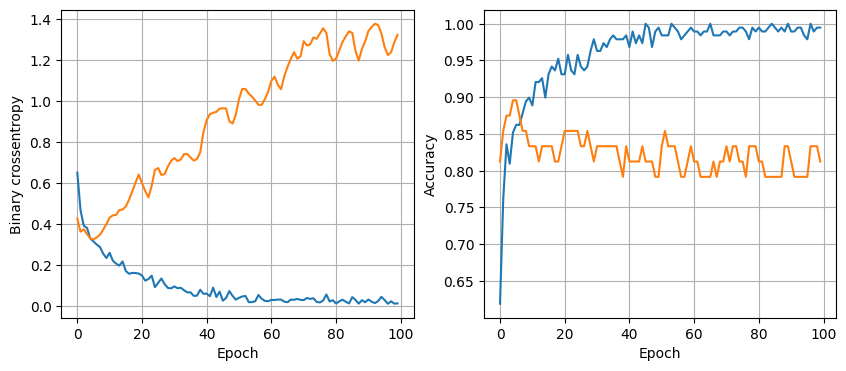

2/2 [==============================] - 0s 7ms/step - loss: 2.4267 - accuracy: 0.7833
64 nodes, dropout 0.2, lr 0.01, batch size 128


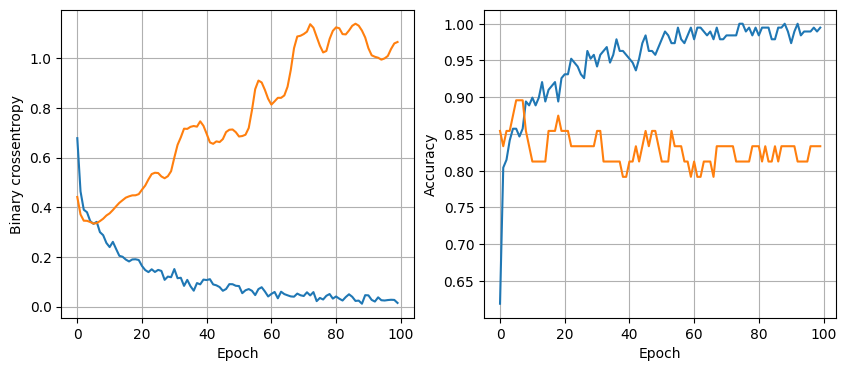

2/2 [==============================] - 0s 8ms/step - loss: 2.0159 - accuracy: 0.8000
64 nodes, dropout 0.2, lr 0.005, batch size 32


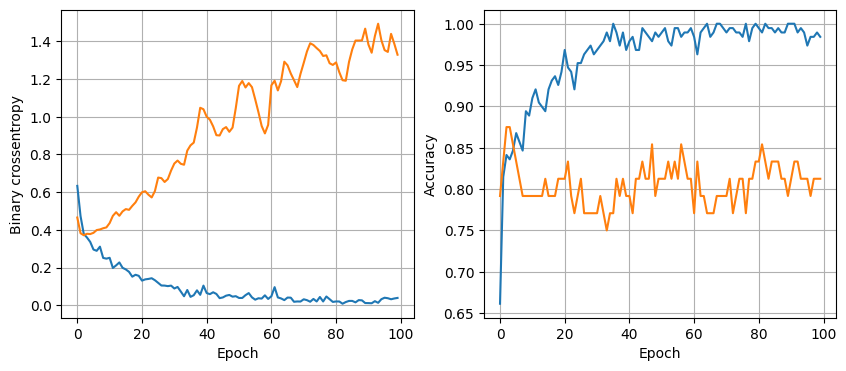

2/2 [==============================] - 0s 8ms/step - loss: 2.3801 - accuracy: 0.7833
64 nodes, dropout 0.2, lr 0.005, batch size 64


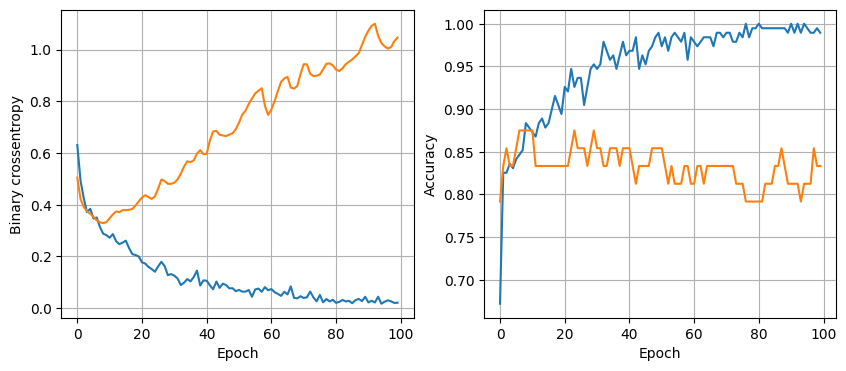

2/2 [==============================] - 0s 8ms/step - loss: 1.8294 - accuracy: 0.7167
64 nodes, dropout 0.2, lr 0.005, batch size 128


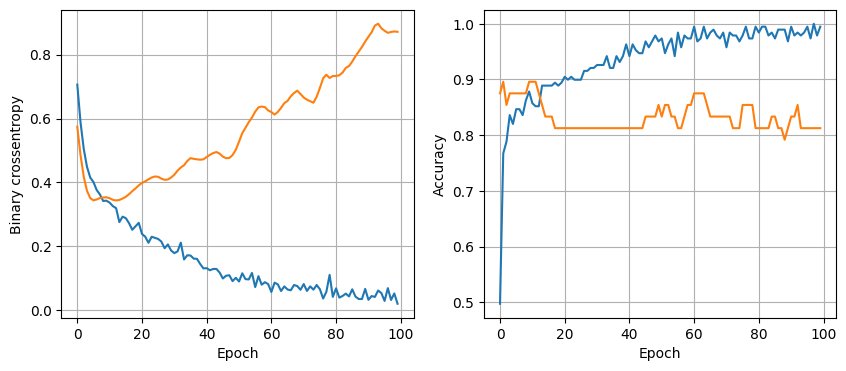

2/2 [==============================] - 0s 7ms/step - loss: 1.6140 - accuracy: 0.7667
64 nodes, dropout 0.2, lr 0.001, batch size 32


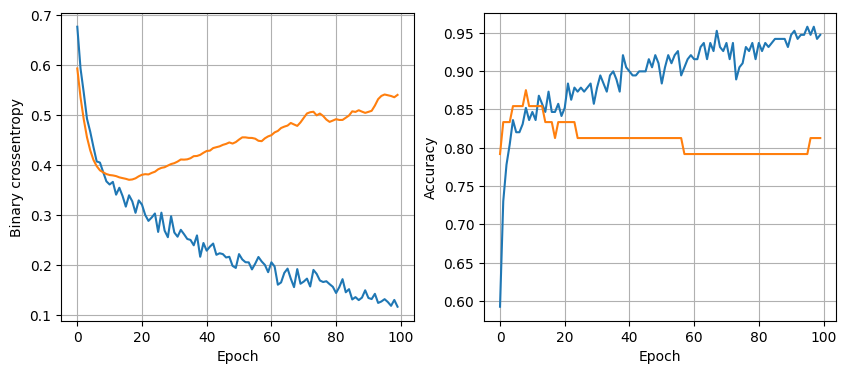

2/2 [==============================] - 0s 7ms/step - loss: 0.8697 - accuracy: 0.7833
64 nodes, dropout 0.2, lr 0.001, batch size 64


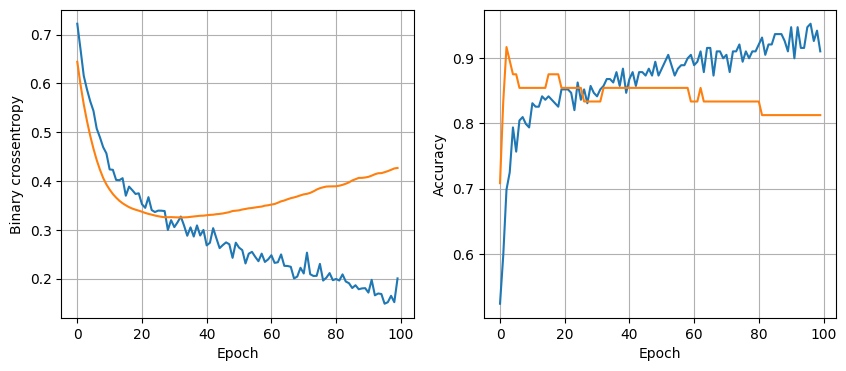

2/2 [==============================] - 0s 7ms/step - loss: 0.7499 - accuracy: 0.8167
64 nodes, dropout 0.2, lr 0.001, batch size 128


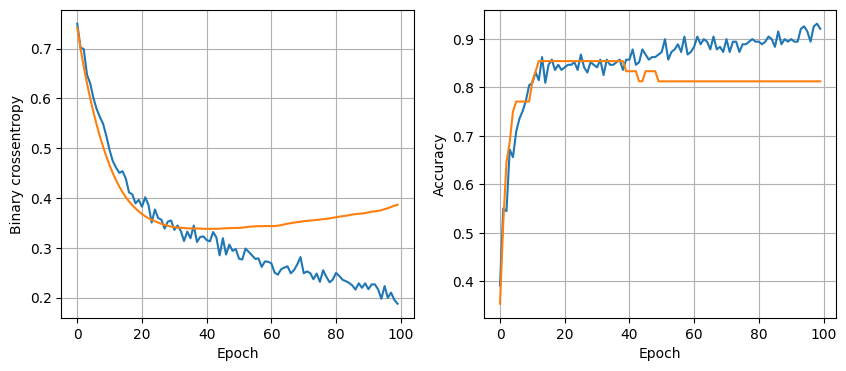

2/2 [==============================] - 0s 6ms/step - loss: 0.5761 - accuracy: 0.8167


In [61]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
for num_nodes in [16, 32, 64]:
  for dropout_prob in[0, 0.2]:
    for lr in [0.01, 0.005, 0.001]:
      for batch_size in [32, 64, 128]:
        print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
        model, history = train_model(x_train_norm, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
        plot_history(history)
        val_loss = model.evaluate(x_test_norm, y_test)[0]
        if val_loss < least_val_loss:
          least_val_loss = val_loss
          least_loss_model = model

In [62]:
y_predict_nn = least_loss_model.predict(x_test_norm)

2/2 [==============================] - 0s 5ms/step


Since we have sigmoid values we need to transform these with a threshold of 0.5.

In [63]:
y_predict_nn = (y_predict_nn > 0.5).astype(int).reshape(-1,)
y_predict_nn

array([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1])

In [64]:
print(classification_report(y_test, y_predict_nn))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82        30
           1       0.79      0.90      0.84        30

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60



RESULTS ANALYSIS

In [73]:
algorithm_analysis = {'Algorithm': ['Log Regression', 'KNN', 'SVM', 'Random Forest', 'Neural Networks'],
                  'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_knn), accuracy_score(y_test, y_pred_svc), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_predict_nn)],
                   'F1-Score': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_knn), f1_score(y_test, y_pred_svc), f1_score(y_test, y_pred_rf), f1_score(y_test, y_predict_nn)]}
compare_algorithms = pd.DataFrame(data=algorithm_analysis)
compare_algorithms

,Algorithm,Accuracy,F1-Score
0,Log Regression,0.800000,0.806452
1,KNN,0.833333,0.821429
2,SVM,0.900000,0.896552
3,Random Forest,0.866667,0.862069
4,Neural Networks,0.833333,0.843750


IMPORT MODEL AND SCALER

In [66]:
import joblib
joblib.dump(svm_model, 'svm_model.sav')
joblib.dump(scaler_test, 'scaler.sav')

['scaler.sav']